# <span style = "background-color: #FFDDDD"> 나를 찾아줘 - Class Activation Map 만들기</span>

⭐️ CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?	ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.  
⭐️ 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?	CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.  
⭐️ 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?	CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

---
## <span style = "background-color: #FFFFDD"> 🐶 Environment Settings</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# useful tools
import os      # environment variable path
import copy    # copy n-d array

# data array
import numpy as np

# image handling
import cv2
import PIL

# visualization
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import tensorflow.keras as keras

# dataset
import tensorflow_datasets as tfds

### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
NUM_CLASSES = 120
IMG_SIZE = 224

In [3]:
# model training configurations
BATCH_SIZE = 16
EPOCHS = 20

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [4]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🐶 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [6]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,
                                        )

print("All dataset downloaded successfully!")

All dataset downloaded successfully!


### <span style = "background-color: #F0E9FF"> 2. Preview dataset</span>

**2-1. Analyze data features**

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [8]:
NUM_CLASSES = ds_info.features["label"].num_classes

**2-2. Preview image data**

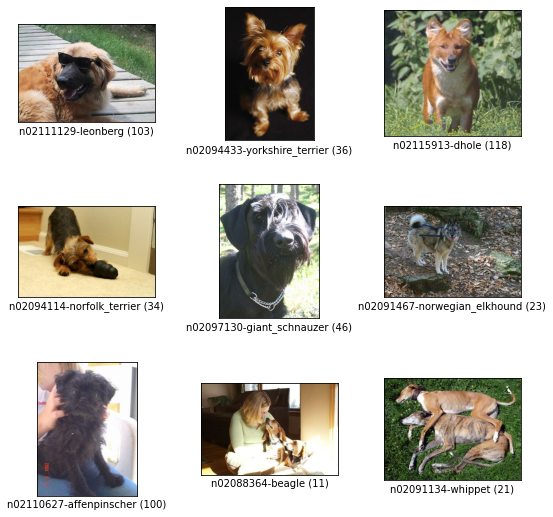

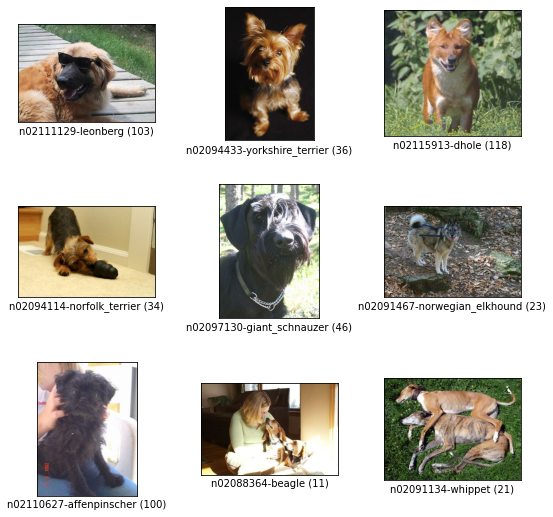

In [9]:
tfds.show_examples(ds_train, ds_info)

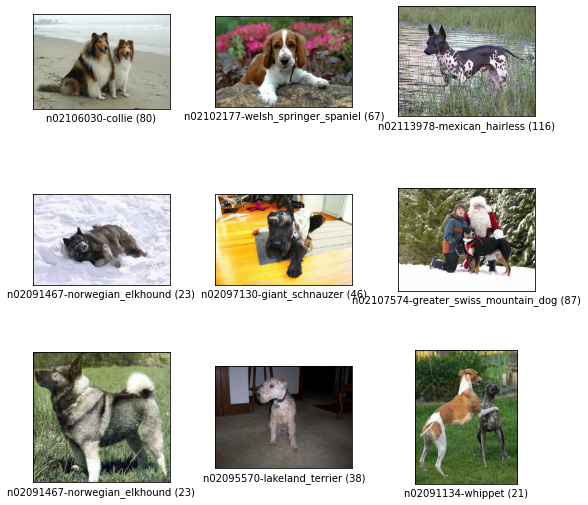

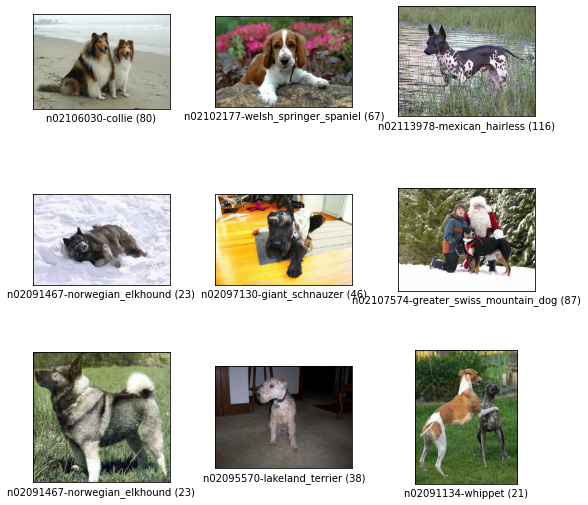

In [10]:
tfds.show_examples(ds_test, ds_info)

**2-3. Define a method to preview one sample randomly from image data**

In [11]:
# define one-sample-preview method
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

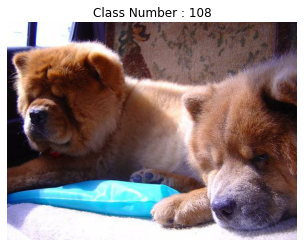

In [12]:
# test operation of one-sample-preview method
item = get_one(ds_test)

plt.imshow(item["image"])
plt.title("Class Number : " + str(item["label"]))
plt.axis("off")
plt.show()

### <span style = "background-color: #F0E9FF"> 3. Pre-process data</span>

**3-1. Define pre-processing methods**

In [13]:
def get_resized_normalized_img(input_data):
    # resize
    image = tf.image.resize(input_data["image"], [IMG_SIZE, IMG_SIZE])
                                       
    # normalize (uint8 -> float32)
    input_data["image"] = tf.cast(image, tf.float32) / 255.
                                       
    return input_data["image"], input_data["label"]


def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE):
    ds = ds.map(get_resized_normalized_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

**3-2. Perform pre-processing on prepared dataset**

In [14]:
# adopt pre-processing on the dataset
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

In [15]:
# check pre-processing result
for inputs in ds_train_norm.take(1):
    image, label = inputs
    print("> Shape of IMAGE data : ", image.shape)
    print("> Shape of LABEL data : ", label.shape)

> Shape of IMAGE data :  (16, 224, 224, 3)
> Shape of LABEL data :  (16,)


---
## <span style = "background-color: #FFFFDD"> 🐶 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Define model structure</span>

In [16]:
def get_cam_from_model(model, num_classes=NUM_CLASSES):
    x = model.output
    preds = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    cam_model = keras.Model(inputs=model.input, outputs=preds)
    return cam_model

### <span style = "background-color: #F0E9FF"> 2. Generate a model instance</span>

**2-1. Load pre-trained ResNet-50 model**

In [17]:
resnet_model = base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)

**2-2. Generate CAM model instance**

In [18]:
cam_model = get_cam_from_model(resnet_model)

In [19]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### <span style = "background-color: #F0E9FF"> 3. Train the model</span>

**3-1. Compile the model**

In [20]:
cam_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  metrics=["accuracy"],
                 )

**3-2. Start training**

In [21]:
history_cam_model = cam_model.fit(ds_train_norm,
    steps_per_epoch=int(ds_info.splits["train"].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits["test"].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 207ms/step - loss: 2.2588 - accuracy: 0.4292 - val_loss: 3.3199 - val_accuracy: 0.2176
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.6445 - accuracy: 0.8289 - val_loss: 1.0963 - val_accuracy: 0.6751
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1705 - accuracy: 0.9770 - val_loss: 1.0244 - val_accuracy: 0.7053
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0561 - accuracy: 0.9969 - val_loss: 0.9635 - val_accuracy: 0.7213
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0327 - accuracy: 0.9984 - val_loss: 0.9585 - val_accuracy: 0.7304
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0195 - accuracy: 0.9996 - val_loss: 0.9567 - val_accuracy: 0.7306
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0169 - accuracy: 0.9992 - val_loss: 0.9714 -

### <span style = "background-color: #F0E9FF"> 4. Visualize training process</span>

**4-1. Define a method to visualize model evaluations**

In [22]:
def visualize_history(history):
    fig = plt.figure(figsize=(15,7))
    
    # visualize training & validation loss
    graph1 = fig.add_subplot(1, 2, 1)
    graph1.plot(history.history["loss"], color="lightpink", label="training")
    graph1.plot(history.history["val_loss"], color="palevioletred", label="validation")
    graph1.set_title("L O S S")
    graph1.set_xlabel("epochs")
    graph1.set_ylabel("loss")
    graph1.grid()
    graph1.legend()
        
    # visualize training & validation accuracy
    graph2 = fig.add_subplot(1, 2, 2)
    graph2.plot(history.history["accuracy"], color="thistle", label="training")
    graph2.plot(history.history["val_accuracy"], color="orchid", label="validation")
    graph2.set_title("A C C U R A C Y")
    graph2.set_xlabel("epochs")
    graph2.set_ylabel("accuracy")
    graph2.grid()
    graph2.legend()    

    fig.tight_layout()
    fig.show()

**4-2. Visualize model evaluation**

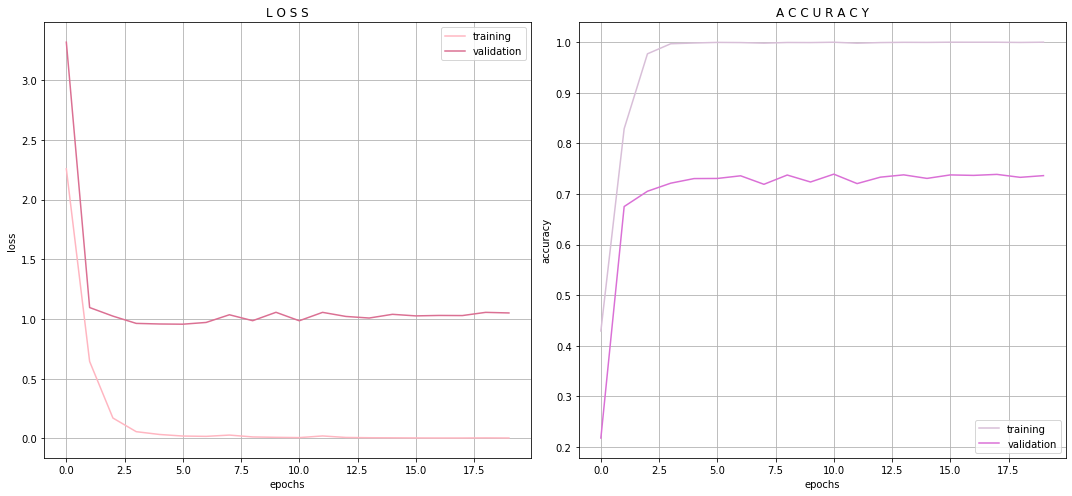

In [23]:
visualize_history(history_cam_model)

---
## <span style = "background-color: #FFFFDD"> 🐶 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Define methods to generate CAM & Grad-CAM images</span>

**1-1. Define a method to generate CAM image**

In [24]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = get_resized_normalized_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

**1-2. Define a method to generate Grad-CAM image**

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = get_resized_normalized_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

**1-3. Define a method to merge original & CAM images**

In [26]:
def visualize_cam_on_img(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

### <span style = "background-color: #F0E9FF"> 2. Define methods to visualize bounding boxes</span>

**2-1. Define a method to convert bounding box format**

In [27]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),    #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),    #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),    #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])     #bounding box의 x_max
    ]
    return bbox

**2-2. Define a method to get bounding box from a CAM image** 

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    
    return rect

**2-3. Define a method to calculate IOU of two bounding boxes**

In [29]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [30]:
def get_pred_bbox_iou(item, cam_image):
    original_bbox = item["objects"]["bbox"][0]
    predicted_bbox = get_bbox(cam_image, is_minmax=True)

### <span style = "background-color: #F0E9FF"> 3. Define a pipeline method to get experimental results</span>

In [31]:
def get_cam_result(cam_model, item):
    
    # get original image
    original_img = item["image"].astype(np.uint8)
    
    # get original bbox
    original_bbox_minmax = item["objects"]["bbox"][0]
    
    
    # get CAM image
    cam_img = generate_cam(cam_model, item)
    
    # get (original + CAM) merged image
    cam_img_3ch = np.stack([cam_img*255]*3, axis=-1).astype(np.uint8)
    cam_blended_img = visualize_cam_on_img(cam_img_3ch, original_img)
    
    # get (original + CAM bbox) merged image
    cam_bbox = get_bbox(cam_img)
    cam_bbox_img = copy.deepcopy(item["image"])
    cam_bbox_img = cv2.drawContours(cam_bbox_img, [cam_bbox], 0, (0,0,255), 2)

    # get IOU of groundtruth & CAM bboxes
    cam_bbox_minmax = rect_to_minmax(cam_bbox, item["image"])
    cam_bbox_iou = get_iou(cam_bbox_minmax, original_bbox_minmax)
    
    
    
    # get Grad-CAM image
    grad_cam_img = generate_grad_cam(cam_model, "conv5_block3_out", item)
    
    # get (original + Grad-CAM) merged image
    grad_cam_img_3ch = np.stack([cam_img*255]*3, axis=-1).astype(np.uint8)
    grad_cam_blended_img = visualize_cam_on_img(grad_cam_img_3ch, original_img)
    
    # get (original + Grad_CAM bbox) merged image
    grad_cam_bbox = get_bbox(grad_cam_img)
    grad_cam_bbox_img = copy.deepcopy(item["image"])
    grad_cam_bbox_img = cv2.drawContours(grad_cam_bbox_img, [grad_cam_bbox], 0, (0,0,255), 2)
    
    # get IOU of groundtruth & Grad-CAM bboxes
    grad_cam_bbox_minmax = rect_to_minmax(grad_cam_bbox, item["image"])
    grad_cam_bbox_iou = get_iou(grad_cam_bbox_minmax, original_bbox_minmax)

    
    result = {"ORIGINAL": original_img,
             "CAM": cam_img,
             "CAM_BLENDED": cam_blended_img,
             "CAM_BBOX": cam_bbox_img,
             "CAM_IOU": cam_bbox_iou,
             "GCAM": grad_cam_img,
             "GCAM_BLENDED": grad_cam_blended_img,
             "GCAM_BBOX": grad_cam_bbox_img,
             "GCAM_IOU": grad_cam_bbox_iou}

    return result

---
## <span style = "background-color: #FFFFDD"> 🐶 Evaluation</span>

### <span style = "background-color: #F0E9FF"> 1. Define a method to visualize results</span>

In [32]:
def visualize_cam_result(cam_result):
    fig = plt.figure(figsize=(15, 7))
    
    img1 = fig.add_subplot(2, 4, 1)
    plt.imshow(cam_result["ORIGINAL"])
    plt.title("Original")
    plt.axis("off")
    
    img2 = fig.add_subplot(2, 4, 2)
    plt.imshow(cam_result["CAM"])
    plt.title("CAM")
    plt.axis("off")
    
    img3 = fig.add_subplot(2, 4, 3)
    plt.imshow(cam_result["CAM_BLENDED"])
    plt.title("Original + CAM")
    plt.axis("off")
    
    img4 = fig.add_subplot(2, 4, 4)
    plt.imshow(cam_result["CAM_BBOX"])
    plt.title("Original + CAM bbox")
    plt.axis("off")
    
    # img5 is for empty space
    
    img6 = fig.add_subplot(2, 4, 6)
    plt.imshow(cam_result["GCAM"])
    plt.title("Grad-CAM")
    plt.axis("off")
    
    img7 = fig.add_subplot(2, 4, 7)
    plt.imshow(cam_result["GCAM_BLENDED"])
    plt.title("Original + Grad-CAM")
    plt.axis("off")
    
    img7 = fig.add_subplot(2, 4, 8)
    plt.imshow(cam_result["GCAM_BBOX"])
    plt.title("Original + Grad-CAM bbox")
    plt.axis("off")
    
    fig.tight_layout()
    fig.show()
    
    print("> IOU of CAM resulted bouding box      : ", cam_result["CAM_IOU"])
    print("> IOU of Grad-CAM resulted bouding box : ", cam_result["GCAM_IOU"])

### <span style = "background-color: #F0E9FF"> 2. Get experimental results and visualize</span>

>💡  
>FOR 반복분을 통해 여러 장의 샘플 이미지 데이터에 대해 실험을 반복하고 싶었으나,  
>fig.show() 함수와 print(IOU) 함수의 출력 순서가 잘 맞지 않아서 그만... 😰  
>본의 아니게 같은 실험 명령 코드를 복붙으로 수동 반복하는 방식으로 실험 수행  

**2-1. Define a method to perform experiment**

In [33]:
def repeat_experiment(ds_test):
    item = get_one(ds_test)
    cam_result = get_cam_result(cam_model, item)
    visualize_cam_result(cam_result)

**2-2. Repeat experiments**

> IOU of CAM resulted bouding box      :  0.6435196348686745
> IOU of Grad-CAM resulted bouding box :  0.6486062845933797


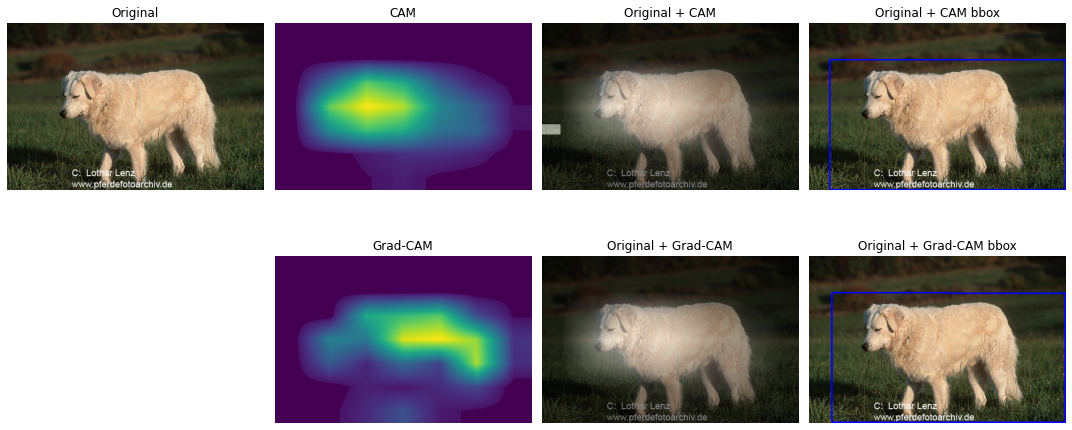

In [34]:
repeat_experiment(ds_test)

> IOU of CAM resulted bouding box      :  0.7437185262191143
> IOU of Grad-CAM resulted bouding box :  0.024930747260869288


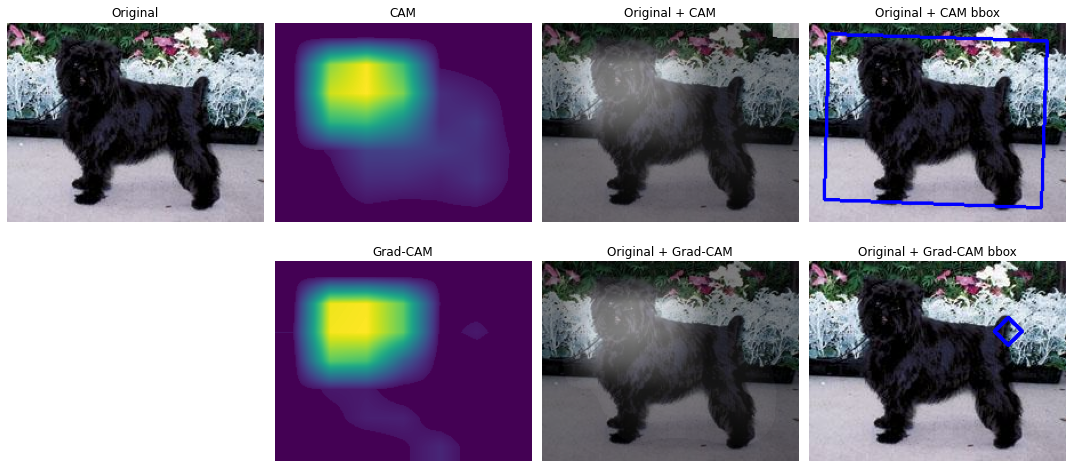

In [36]:
repeat_experiment(ds_test)

> IOU of CAM resulted bouding box      :  0.684247502009999
> IOU of Grad-CAM resulted bouding box :  0.5929398518915161


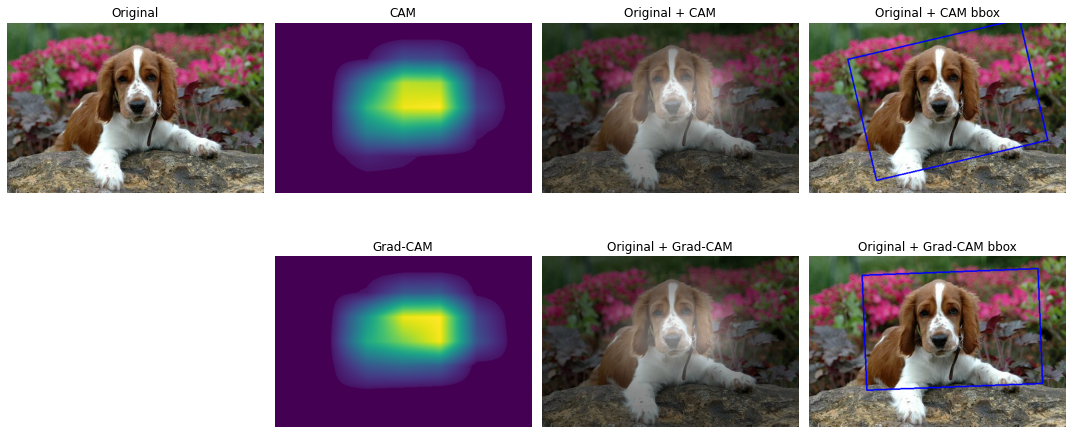

In [37]:
repeat_experiment(ds_test)

> IOU of CAM resulted bouding box      :  0.34990079901916127
> IOU of Grad-CAM resulted bouding box :  0.0016027041346337422


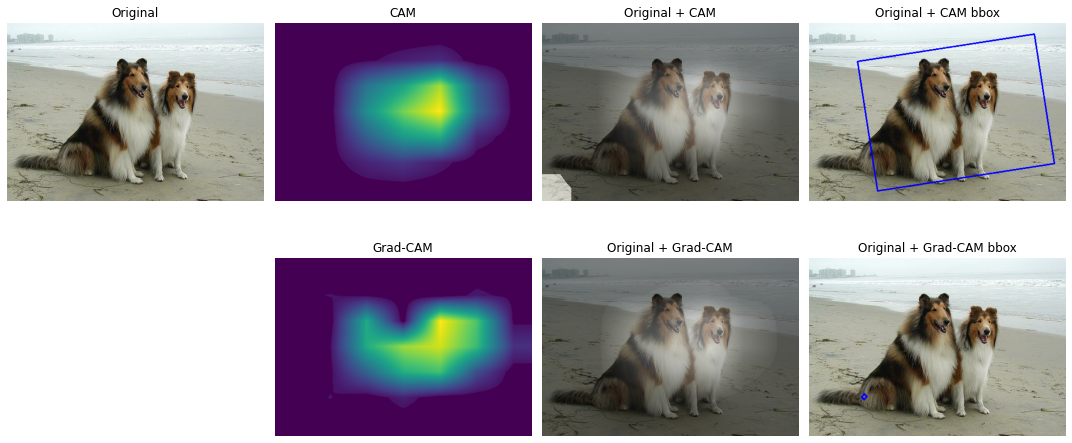

In [38]:
repeat_experiment(ds_test)

> IOU of CAM resulted bouding box      :  0.4540093992408452
> IOU of Grad-CAM resulted bouding box :  0.4106134537548689


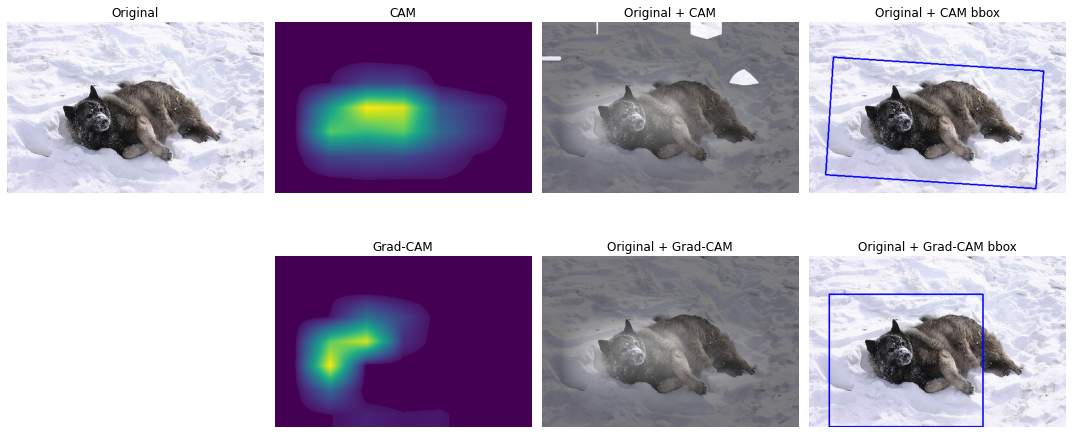

In [39]:
repeat_experiment(ds_test)

---
## <span style = "background-color: #FFFFDD"> 🐶 Conclusion</span>

**📝 실험결과 분석**

- CAM/Grad-CAM 결과 이미지로만 판단했을 때에는, CAM은 개의 머리 부분에 집중적으로 (정확한 표현은 아니지만) feature detection을 수행하고 Grad-CAM은 몸통 부분까지 다소 확장된 면적으로 feature detection을 수행하는 듯 하였다.

  - 첫번째 실험은 우연히 같은 데이터 샘플이 채택된 듯 경우, 이미지 아랫 부분에 개와 유사한 색상의 텍스트가 표시되어 있는데, Grad-CAM은 이 부분까지 몸통으로 인식하는 듯 했다. 
  
  - 두번째/다섯번째 실험은 CAM이 Grad-CAM보다 개에 해당하는 부분을 명확하게 짚어냈다.
  
  - 사실 엄밀히 말하면 CAM/Grad-CAM은 개의 종류를 분류하기 위한 가장 "특징적"인 부분을 밝혀내는 것이지, 개의 detection 및 segmentation을 위한 알고리즘은 아니므로, 실제 개의 위치/면적과는 다소 차이가 있는 것이 당연할 것이다.
  
  
- CAM 이미지로부터 bounding box를 추출하는 함수가 제대로 작동되지 않는 듯 하다. CAM의 경우 대부분의 실험에서 이미지와 bounding box 추출 결과가 유사한 형상을 띄고 있으나, Grad-CAM의 경우 두번째/네번째 실험에서 이미지와 bounding box 추출 결과가 전혀 다른 양상을 띠는 경우가 발생하였다.
  - bounding box가 제대로 추출되지 않으니 IOU 또한 제대로 계산되지 않아 CAM과 Grad-CAM의 정량적 비교는 어려울 것이다.
  - Grad-CAM의 bounding box 추출이 되지 않는 두번째/네번째 실험을 아예 배제하고, 첫번째/세번째/다섯번째 실험의 IOU만 고려한다면, CAM의 성능이 높은 경우와 Grad-CAM의 성능이 높은 경우가 고르게 존재한다. 이번 실험만으로는 어느 알고리즘이 더 좋다고 판단하기 어려울 것 같다.

**📝 회고록**  
- 사전 훈련된 모델을 불러와서 그런건지, EPOCHS=5 이후로는 별다른 성능 향상을 관찰할 수 없었다.
- XAI는 완전히 처음 들어본 개념이였는데, 블랙박스로만 진행되는 딥러닝의 과정을 조금이나마 시각화해서 확인할 수 있다는 점이 매우 신기했다.
- 귀여운 고양이, 강아지 사진들을 다루니 프로그래밍의 피로도가 덜 누적되는 것 같다 😄 히히

---